In [10]:
#1. Загрузка библиотек

In [1]:
import pandas as pd
import os
from tqdm import tqdm
from nltk.tokenize import wordpunct_tokenize
from nltk.corpus import stopwords
from pymorphy2 import MorphAnalyzer
import gensim
import pyLDAvis.gensim_models as gensimvis
import pyLDAvis

In [2]:
#2. Загрузка датафрейма и предобработка текста

In [4]:
SecurityLab = pd.read_csv("SecurityLab(8000).csv", encoding = "UTF-8", sep = ",")
full_texts = list(SecurityLab["Text"])

In [5]:
morph = MorphAnalyzer()
stop_words = stopwords.words('russian')

C:\Users\andre\AppData\Local\Programs\Python\Python310\lib\site-packages\pymorphy2\units\base.py:70: DeprecationWarning: inspect.getargspec() is deprecated since Python 3.0, use inspect.signature() or inspect.getfullargspec()
  args, varargs, kw, default = inspect.getargspec(cls.__init__)
C:\Users\andre\AppData\Local\Programs\Python\Python310\lib\site-packages\pymorphy2\units\base.py:70: DeprecationWarning: inspect.getargspec() is deprecated since Python 3.0, use inspect.signature() or inspect.getfullargspec()
  args, varargs, kw, default = inspect.getargspec(cls.__init__)
C:\Users\andre\AppData\Local\Programs\Python\Python310\lib\site-packages\pymorphy2\units\base.py:70: DeprecationWarning: inspect.getargspec() is deprecated since Python 3.0, use inspect.signature() or inspect.getfullargspec()
  args, varargs, kw, default = inspect.getargspec(cls.__init__)
C:\Users\andre\AppData\Local\Programs\Python\Python310\lib\site-packages\pymorphy2\units\base.py:70: DeprecationWarning: inspect.g

In [6]:
def preprocess(text):
    tokens = wordpunct_tokenize(text)
    lemmatized = [morph.parse(item)[0].normal_form for item in tokens]
    lemmatized = [token for token in lemmatized if token.isalpha()]
    clean_text = [word for word in lemmatized if word not in stop_words]
    return clean_text

In [7]:
preprocessed_texts = [preprocess(text) for text in tqdm(full_texts)]

100%|██████████████████████████████████████████████████████████████████████████████| 8009/8009 [19:08<00:00,  6.97it/s]


In [ ]:
#3. Тематическое моделирование предобработанного текста

In [9]:
#превратить список текстов в специальный объект для библиотеки Gensim
gensim_dictionary_for_TM = gensim.corpora.Dictionary(preprocessed_texts)

# удалить из корпуса слова:
# которые встречаются более чем в 10% документах корпуса (no_above=0.1)
# и менее чем в 20 документах (no_below=20)
gensim_dictionary_for_TM.filter_extremes(no_above=0.2, no_below=20)

# сжать словарь после того, как убраны лишние слова
gensim_dictionary_for_TM.compactify()

# посмотреть словарь
print(gensim_dictionary_for_TM)

Dictionary<4973 unique tokens: ['android', 'apk', 'app', 'apple', 'c']...>


In [10]:
#преобразовать тексты в bags of words:

corpus = [gensim_dictionary_for_TM.doc2bow(text) for text in preprocessed_texts]

In [14]:
# обучение модели для тематического моделирования
lda = gensim.models.LdaMulticore(corpus, 
                                 num_topics = 20, # число топиков
                                 id2word=gensim_dictionary_for_TM, 
                                 passes=40)

In [15]:
lda.print_topics()

[(0,
  '0.019*"linux" + 0.011*"сервер" + 0.010*"pt" + 0.010*"протокол" + 0.009*"сертификат" + 0.008*"сетевой" + 0.007*"управление" + 0.007*"версия" + 0.006*"анализ" + 0.006*"трафик"'),
 (1,
  '0.011*"кибербезопасность" + 0.009*"technologies" + 0.009*"positive" + 0.008*"угроза" + 0.007*"число" + 0.007*"количество" + 0.006*"рост" + 0.006*"защита" + 0.006*"уровень" + 0.006*"большой"'),
 (2,
  '0.083*"microsoft" + 0.061*"windows" + 0.028*"обновление" + 0.017*"версия" + 0.015*"проблема" + 0.008*"server" + 0.008*"exchange" + 0.007*"azure" + 0.007*"ошибка" + 0.006*"сбой"'),
 (3,
  '0.074*"google" + 0.029*"банк" + 0.026*"реклама" + 0.014*"fi" + 0.013*"рекламный" + 0.013*"wi" + 0.010*"поисковый" + 0.010*"биометрический" + 0.009*"chrome" + 0.009*"конфиденциальность"'),
 (4,
  '0.024*"группировка" + 0.021*"вымогатель" + 0.017*"вымогательский" + 0.013*"выкуп" + 0.011*"кибератака" + 0.008*"инцидент" + 0.007*"атаковать" + 0.007*"похитить" + 0.006*"опубликовать" + 0.006*"файл"'),
 (5,
  '0.016*"челов

In [16]:
# Посмотреть распределение на конкретном тексте:

lda[corpus[0]]

[(3, 0.11160941),
 (6, 0.023944702),
 (8, 0.053148214),
 (14, 0.6925854),
 (17, 0.11604204)]

In [17]:
full_texts[0]

'Корпорации Apple и Google уже давно сталкиваются с критикой со стороны регулирующих органов в Европе по поводу того, насколько жестко они контролируют распространение программного обеспечения на своих мобильных платформах. Теперь аналогичная риторика идёт по другую сторону Атлантики. В новом отчете Белого дома, посвящённом усилении конкуренции на рынках мобильных предложений, было предложено принять закон, который бы обязал сделать экосистемы мобильного ПО Apple и Google более открытыми. В обширной рецензии утверждается, что iOS и Android в настоящее время подавляют конкуренцию между разработчиками ненужными препятствиями. Национальное управление телекоммуникаций и информации Министерства торговли (NTIA) перечислило несколько ключевых тезисов в своём заявлении:«Потребители должны иметь больше контроля над своими устройствами. Они должны иметь возможность выбирать приложения по умолчанию, использовать альтернативные магазины, удалять или скрывать предустановленные приложения». «Apple н

In [ ]:
# оценка результатов работы модели с помощью параметра Coherence score по метрике c_v

In [18]:
from gensim.models import CoherenceModel
coherence_model_lda = CoherenceModel(model=lda,
                                     texts=preprocessed_texts,
                                     dictionary=gensim_dictionary_for_TM,
                                     coherence="c_v")
coherence_lda = coherence_model_lda.get_coherence()
 
print("\nCoherence Score: ", coherence_lda)



Coherence Score:  0.5737120079889078


In [ ]:
# оценка качества тематического моделирования по отношению к количеству тем, метрика c_uci

In [23]:
def coherence_score(dictionary, corpus, texts, max, start=2, step=3,
                    measure="c_uci"):
    """
    Функция вычисляет метрики для оценки тем. моделирования и выводит 
    график, где по оси x отложено количество топиков, а по оси y — значение 
    метрики
    :param dictionary: словарь для тематического моделирования
    :param corpus: корпус в виде мешка слов
    :param texts: тексты документов
    :param max: максимальное количество топиков
    :param start: стартовое количество топиков
    :param step: промежуток, с которым вычисляются топики
    :param measure: метрика
    """
    coherence_values = []
    for num_topics in range(start, max, step):
        model = gensim.models.LdaMulticore(corpus=corpus, id2word=dictionary, 
                                           passes=10, num_topics=num_topics, 
                                           random_state=6457)
        coherencemodel = CoherenceModel(model=model, texts=texts, 
                                        dictionary=dictionary, 
                                        coherence=measure)
        coherence_values.append(coherencemodel.get_coherence())
    x = range(start, max, step)
    plt.plot(x, coherence_values)
    plt.xlabel("Number of Topics")
    plt.ylabel(measure + "score")
    plt.legend(("coherence_score"), loc='best')
    plt.show()

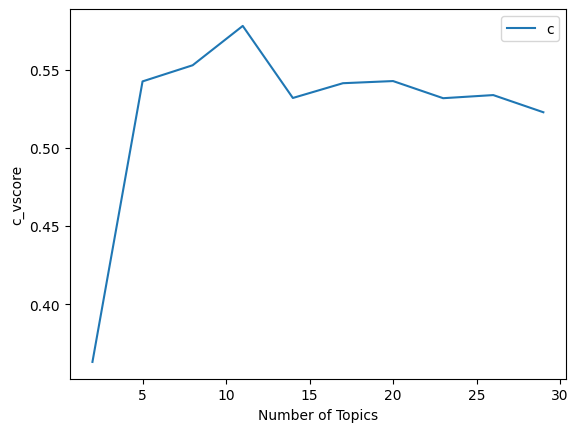

In [56]:
import matplotlib.pyplot as plt
 
coherence_score(dictionary=gensim_dictionary_for_TM, corpus=corpus, texts=preprocessed_texts, start=2, max=30, step=3, measure="c_v")

In [ ]:
# Визуализация

In [19]:
vis = gensimvis.prepare(lda, corpus, gensim_dictionary_for_TM)

pyLDAvis.enable_notebook()

vis

C:\Users\andre\AppData\Local\Programs\Python\Python310\lib\site-packages\pyLDAvis\_prepare.py:247: FutureWarning: In a future version of pandas all arguments of DataFrame.drop except for the argument 'labels' will be keyword-only.
  by='saliency', ascending=False).head(R).drop('saliency', 1)


PreparedData(topic_coordinates=              x         y  topics  cluster      Freq
topic                                               
6     -0.148296  0.116258       1        1  8.771786
17     0.138100 -0.050269       2        1  8.597932
4      0.080426  0.078504       3        1  8.249780
5      0.004955 -0.107165       4        1  7.087694
8      0.169481 -0.102624       5        1  6.872589
1     -0.011950 -0.173069       6        1  6.268750
13    -0.179214  0.071816       7        1  5.314761
16     0.166939  0.063432       8        1  4.786751
9     -0.035789  0.103748       9        1  4.586177
10    -0.173089 -0.048578      10        1  4.428235
11     0.132343  0.002541      11        1  4.297606
15     0.050901  0.172670      12        1  3.983816
7      0.209248  0.080929      13        1  3.926737
14    -0.110825  0.064019      14        1  3.830917
12    -0.057591 -0.111728      15        1  3.802109
19    -0.014787 -0.217681      16        1  3.799866
18     0.033240  0.083616      17        1  3.567629
0     -0.183585 -0.043262      18        1  3.297407
2     -0.134512  0.045877      19        1  2.620252
3      0.064006 -0.029034      20        1  1.909206, topic_info=             Term         Freq        Total Category  logprob  loglift
687     microsoft  2649.000000  2649.000000  Default  30.0000  30.0000
119    приложение  3819.000000  3819.000000  Default  29.0000  29.0000
6          google  2279.000000  2279.000000  Default  28.0000  28.0000
1306      windows  2066.000000  2066.000000  Default  27.0000  27.0000
170           cve  2113.000000  2113.000000  Default  26.0000  26.0000
...           ...          ...          ...      ...      ...      ...
1050       запрос    82.803569   938.598802  Topic20  -5.3653   1.5306
742    технология    85.501145  1954.321573  Topic20  -5.3332   0.8292
134         рынок    78.235947   974.326803  Topic20  -5.4220   1.4365
930      политика    69.893251   545.245796  Topic20  -5.5348   1.9042
26    возможность    69.504736  1882.293222  Topic20  -5.5404   0.6596

[1268 rows x 6 columns], token_table=      Topic      Freq    Term
term                         
3843      1  0.225994  active
3843      7  0.043047  active
3843      9  0.021523  active
3843     10  0.043047  active
3843     16  0.086093  active
...     ...       ...     ...
1694      8  0.004705  яндекс
1694     11  0.004705  яндекс
1694     12  0.014114  яндекс
1694     16  0.079977  яндекс
1694     17  0.710386  яндекс

[7794 rows x 3 columns], R=30, lambda_step=0.01, plot_opts={'xlab': 'PC1', 'ylab': 'PC2'}, topic_order=[7, 18, 5, 6, 9, 2, 14, 17, 10, 11, 12, 16, 8, 15, 13, 20, 19, 1, 3, 4])

In [ ]:
# Назначение новых тегов

In [20]:
# один тег на тему

def get_topic(words, lda):
    """
    Функция назначает документу наиболее вероятный топик
    :param words: лемматизированный текст документа
    :param lda: тематическая модель
    :return: список из наиболее вероятного топика 
    и его вероятности
    """
    bag = lda.id2word.doc2bow(words)
    topics = lda.get_document_topics(bag)
    topic_dictionary = {}
    for topic in topics:
        topic_dictionary[topic[1]] = str((topic[0])) 
    main_probability = max(topic_dictionary)
    main_topic = topic_dictionary[main_probability]
    return [main_topic, main_probability]

In [ ]:
# несколько тегов на тему
sorted(zip(score, name), reverse=True)[:3]

def get_topic(words, lda):
    """
    Функция назначает документу наиболее вероятный топик
    :param words: лемматизированный текст документа
    :param lda: тематическая модель
    :return: список из наиболее вероятного топика 
    и его вероятности
    """
    bag = lda.id2word.doc2bow(words)
    topics = lda.get_document_topics(bag)
    topic_dictionary = {}
    for topic in topics:
        topic_dictionary[topic[1]] = str((topic[0])) 
    main_probability = max(topic_dictionary)
    main_topic = topic_dictionary[main_probability]
    return [main_topic, main_probability]

In [24]:
# применить ко всему датасету

SecurityLab["lda"] = SecurityLab["preprocessed_texts"].apply(get_topic, lda=lda)

KeyError: 'preprocessed_texts'

In [ ]:
SecurityLab["topic"] = SecurityLab["lda"].str[0]
SecurityLab["probability"] = SecurityLab["lda"].str[1]
del SecurityLab["lda"]

In [ ]:
# визуализировать данные

import seaborn as sns
 
sns.catplot(x="genre", y="topic", kind="swarm", data=SecurityLab, height=5, aspect=3)
